# Hourly Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def get_enhanced_exog(index):
    exog = pd.DataFrame(index=index)
    for i in range(1, 3):
        exog[f'hr_sin_{i}'] = np.sin(2 * i * np.pi * index.hour / 24)
        exog[f'hr_cos_{i}'] = np.cos(2 * i * np.pi * index.hour / 24)
    exog['is_weekend'] = (index.dayofweek >= 5).astype(int)
    return exog

In [ ]:
df = pd.read_csv('../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_filtered = df[df['DATETIME'].dt.year < 2025].copy().set_index('DATETIME')

# Training Window: Using 1 year of data to get a stable annual mean
data_train = df_filtered['CARBON_INTENSITY'].resample('H').mean().interpolate().tail(24 * 365)
exog_train = get_enhanced_exog(data_train.index)

# Actual 2025 data for comparison
df_2025 = df[df['DATETIME'].dt.year == 2025].copy().set_index('DATETIME')
actual_2025 = df_2025['CARBON_INTENSITY'].resample('H').mean().interpolate()

In [ ]:
model = SARIMAX(data_train, 
                exog=exog_train,
                order=(1, 0, 1),            # d=0: No trend integration
                seasonal_order=(1, 0, 1, 24), # D=0: No seasonal drift
                trend='c',                 # 'c': Anchor to the mean
                enforce_stationarity=True,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

In [ ]:
exog_forecast = get_enhanced_exog(actual_2025.index)
forecast_result = model_fit.get_forecast(steps=len(actual_2025), exog=exog_forecast)
forecast_mean = forecast_result.predicted_mean

C:\Users\tianw\AppData\Local\Temp\ipykernel_20560\2415705448.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_train = df_filtered['CARBON_INTENSITY'].resample('H').mean().interpolate().tail(24 * 365)
C:\Users\tianw\AppData\Local\Temp\ipykernel_20560\2415705448.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  actual_2025 = df_2025['CARBON_INTENSITY'].resample('H').mean().interpolate()


Fitting Mean-Reverting SARIMAX...


c:\Users\tianw\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


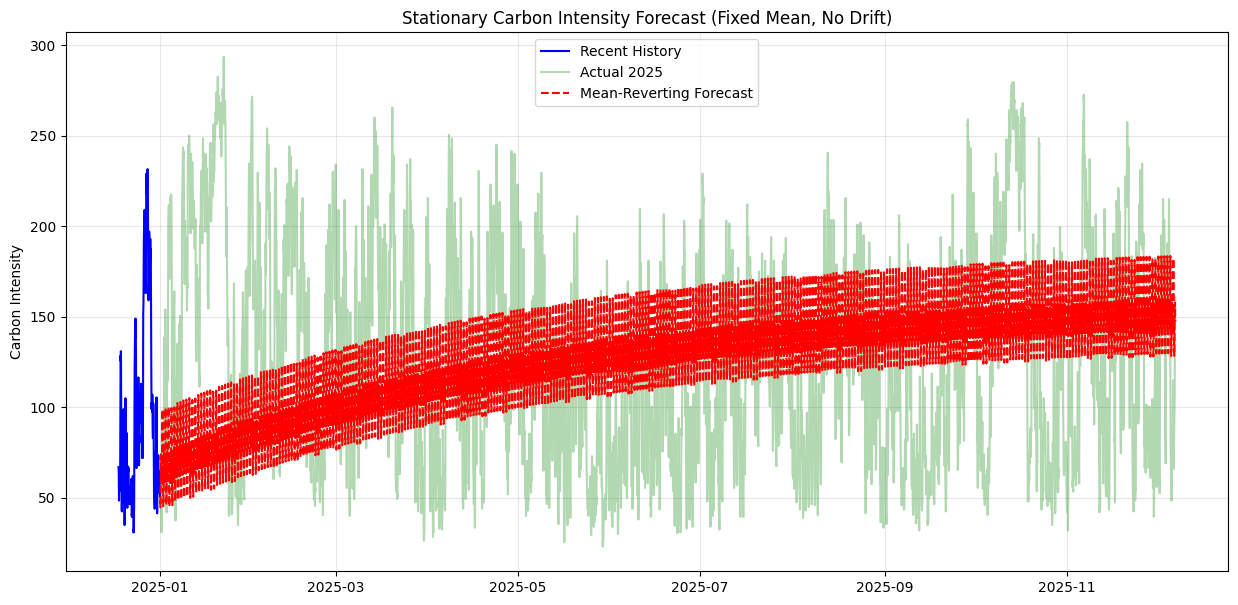

MAE: 54.24, RMSE: 65.98


In [ ]:
mae = mean_absolute_error(actual_2025, forecast_mean)
rmse = np.sqrt(mean_squared_error(actual_2025, forecast_mean))

plt.figure(figsize=(15, 7))
plt.plot(data_train.tail(24*14).index, data_train.tail(24*14), label='Recent History', color='blue')
plt.plot(actual_2025.index, actual_2025, label='Actual 2025', color='green', alpha=0.3)
plt.plot(forecast_mean.index, forecast_mean, label='Mean-Reverting Forecast', color='red', linestyle='--')

plt.title("Stationary Carbon Intensity Forecast (Fixed Mean, No Drift)")
plt.ylabel('Carbon Intensity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")